<a href="https://colab.research.google.com/github/klaropls/MLBootcamp2024/blob/main/MLBootcamp2024_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from google.colab import files

Extracting and preparing the dataset.

In [2]:
url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv'

In [3]:
df = pd.read_csv(url)
print(df.head())

                                              Laptop Status   Brand  \
0  ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...    New    Asus   
1  Alurin Go Start Intel Celeron N4020/8GB/256GB ...    New  Alurin   
2  ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...    New    Asus   
3  MSI Katana GF66 12UC-082XES Intel Core i7-1270...    New     MSI   
4  HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...    New      HP   

        Model            CPU  RAM  Storage Storage type       GPU  Screen  \
0  ExpertBook  Intel Core i5    8      512          SSD       NaN    15.6   
1          Go  Intel Celeron    8      256          SSD       NaN    15.6   
2  ExpertBook  Intel Core i3    8      256          SSD       NaN    15.6   
3      Katana  Intel Core i7   16     1000          SSD  RTX 3050    15.6   
4         15S  Intel Core i5   16      512          SSD       NaN    15.6   

  Touch  Final Price  
0    No      1009.00  
1    No       299.00  
2    No       789.00  
3    No      1199.

In [4]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [5]:
print(df.columns)

Index(['laptop', 'status', 'brand', 'model', 'cpu', 'ram', 'storage',
       'storage_type', 'gpu', 'screen', 'touch', 'final_price'],
      dtype='object')


In [6]:
df_new = df[['ram','storage','screen','final_price']]

In [7]:
print(df_new.head())

   ram  storage  screen  final_price
0    8      512    15.6      1009.00
1    8      256    15.6       299.00
2    8      256    15.6       789.00
3   16     1000    15.6      1199.00
4   16      512    15.6       669.01


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

<Axes: xlabel='final_price', ylabel='Count'>

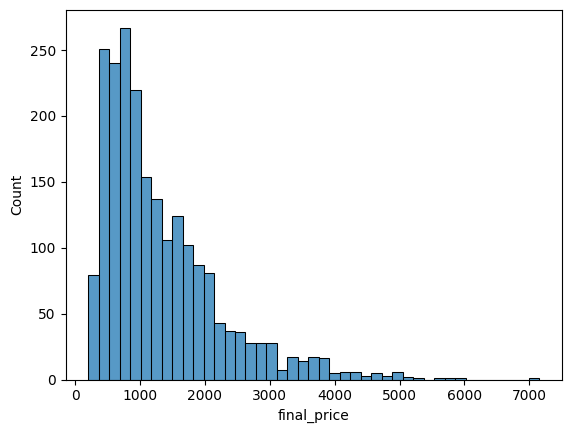

In [9]:
sns.histplot(df_new.final_price)

Question 1
There's one column with missing values. What is it?

We could simply use the isnull() function to find the missing elements. By composing it with .sum(), we find the total number of missing entries per column.

**Ans: screen**

In [10]:
df_new.isnull().sum()

,0
ram,0
storage,0
screen,4
final_price,0


Question 2
What's the median (50% percentile) for variable 'ram'?

This is very straightforward to answer with the .median() function.

**Ans: 16.0**

In [11]:
df_new.ram.median()

16.0

Question 3

    We need to deal with missing values for the column from Q1.
    We have two options: fill it with 0 or with the mean of this variable.
    Try both options. For each, train a linear regression model without regularization using the code from the lessons.
    For computing the mean, use the training only!
    Use the validation dataset to evaluate the models and compare the RMSE of each option.
    Round the RMSE scores to 2 decimal digits using round(score, 2)
    Which option gives better RMSE?

Options:

    With 0
    With mean
    Both are equally good


We first need to split the dataset.
Our first task is to shuffle the index to randomize the distribution of the dataset. We do it as follows:

In [12]:
n = len(df_new)
idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)
print(idx)

[2079  668 2073 ... 1130 1294  860]


Now that we see the indices are shuffled, we split the validation/testing/training dataset into 20%/20%/60%. This can be done in a straightforward manner as follows.

Note that it is best to write n_train as n - n_val - n_test over int(n*0.6) to avoid unnecessary index lost.

In [13]:
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

In [14]:
n_val, n_test, n_train

(432, 432, 1296)

In [15]:
df_train = df_new.iloc[idx[:n_train]]
df_val = df_new.iloc[idx[n_train:n_train+n_val]]
df_test = df_new.iloc[idx[n_train+n_val:]]

Now that we've split them accordingly, we can make the data look cleaner by dropping the (random) indices.

In [16]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [17]:
y_train = df_train.final_price.values
y_val = df_val.final_price.values
y_test = df_test.final_price.values

It is then best to delete the y column of the data to avoid mistraining and confusion.

In [18]:
del df_train['final_price']
del df_val['final_price']
del df_test['final_price']

In [19]:
base = ['ram', 'storage', 'screen']

In [20]:
def prepare_X0(df):
	df_num = df[base]
	df_num = df_num.fillna(0)
	X = df_num.values
	return X

In [21]:
def prepare_Xmean(df):
	df_num = df[base]
	df_num = df_num.fillna(16.0)
	X = df_num.values
	return X

In [22]:
def train_linear_regression(X,y):
  ones = np.ones(X.shape[0])
  X = np.column_stack([ones,X])

  XTX = X.T.dot(X)
  XTX_inv = np.linalg.inv(XTX)
  w_full = XTX_inv.dot(X.T).dot(y)

  return w_full[0], w_full[1:]

In [23]:
X_train0 = prepare_X0(df_train)
X_trainmean = prepare_Xmean(df_train)

In [24]:
w0_0, w_0 = train_linear_regression(X_train0,y_train)
w0_mean, w_mean = train_linear_regression(X_trainmean,y_train)

In [25]:
y_pred0 = w0_0 + X_train0.dot(w_0)
y_predmean = w0_mean + X_trainmean.dot(w_mean)

<Axes: ylabel='Count'>

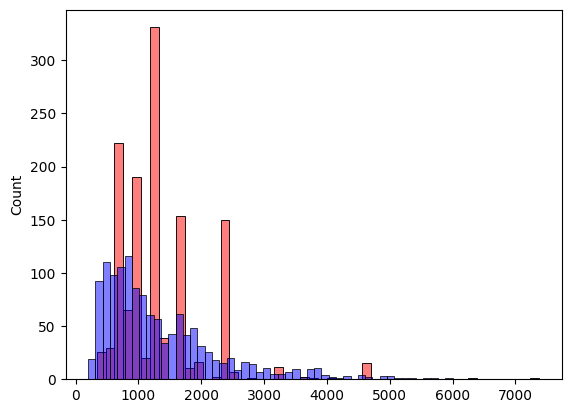

In [26]:
sns.histplot(y_pred0, color = 'red', alpha = 0.5, bins = 50)
sns.histplot(y_train, color = 'blue', alpha = 0.5, bins = 50)

<Axes: ylabel='Count'>

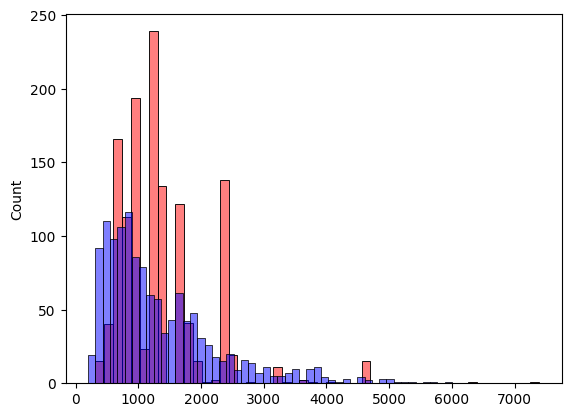

In [27]:
sns.histplot(y_predmean, color = 'red', alpha = 0.5, bins = 50)
sns.histplot(y_train, color = 'blue', alpha = 0.5, bins = 50)

In [28]:
def rmse(y,y_pred):
  se = (y - y_pred) ** 2
  mse = se.mean()
  return np.sqrt(mse)

In [57]:
rmse0 = round(rmse(y_pred0,y_train),2)
rmsemean = round(rmse(y_predmean,y_train),2)
print(rmse0-rmsemean)

-0.03999999999996362


In [30]:
print(rmse0, rmsemean)

602.39 602.22


They have the same RMSE. If we were not to round them off, we'd find that rmse0-rmsemean > 0. This means that using the mean value to fill up the missing column would be *slightly* a bit better.

Question 4

    Now let's train a regularized linear regression.
    For this question, fill the NAs with 0.
    Try different values of r from this list: [0, 0.01, 0.1, 1, 5, 10, 100].
    Use RMSE to evaluate the model on the validation dataset.
    Round the RMSE scores to 2 decimal digits.
    Which r gives the best RMSE?

If there are multiple options, select the smallest r.

Options:

    0
    0.01
    1
    10
    100


In [31]:
def train_linear_regression_reg(X, y, r = 0.001):
  ones = np.ones(X.shape[0])
  X = np.column_stack([ones,X])

  XTX = X.T.dot(X)
  XTX = XTX + r * np.eye(XTX.shape[0])

  XTX_inv = np.linalg.inv(XTX)
  w_full = XTX_inv.dot(X.T).dot(y)

  return w_full[0], w_full[1:]

In [32]:
r = [0, 0.01, 0.1, 1, 5, 10, 100]

w0r_values = []
wr_values = []

for i, r_val in enumerate(r):
    x_i, y_i = train_linear_regression_reg(X_train0, y_train, r_val)
    w0r_values.append(x_i)
    wr_values.append(y_i)

In [33]:
y_predr = []

for i in range(len(w0r_values)):
    y_pred_i = w0r_values[i] + X_train0.dot(wr_values[i])
    y_predr.append(y_pred_i)

In [34]:
rmse_values = []

for i in range(len(y_predr)):
    rmse_i = round(rmse(y_predr[i], y_train),2)
    rmse_values.append(rmse_i)

min_value = np.min(rmse_values)
indices_of_min_value = [i for i, v in enumerate(rmse_values) if v == min_value]
print(indices_of_min_value)

[0, 1, 2]


In [35]:
print(rmse_values)

[602.39, 602.39, 602.39, 602.41, 602.71, 603.13, 604.99]




Question 5

We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
For each seed, do the train/validation/test split with 60%/20%/20% distribution.
Fill the missing values with 0 and train a model without regularization.
For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
Round the result to 3 decimal digits (round(std, 3))

What's the value of std?

19.176
29.176
39.176
49.176

In [36]:
s = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [37]:
n = len(df_new)
idx_s = np.arange(n)

shuffled_indices = []

for seed in s:
    np.random.seed(seed)
    idx = idx_s.copy()
    np.random.shuffle(idx)
    shuffled_indices.append(idx)

for idx in shuffled_indices:
    print(idx)

[ 175  264 2131 ...  763  835 1653]
[ 986  389   65 ... 1096  235 1061]
[1510 1766  370 ...  674 1099 1608]
[ 679  632  756 ... 1667 1688 1898]
[1089 1023  189 ...  709  174 1146]
[ 945  424 1544 ... 2121 1424 1725]
[2020  263  925 ...  618 2004  227]
[1288  262 2137 ...  537 1220  175]
[ 916 2016  332 ... 2033 1364  451]
[2003  502  896 ...  501  348  382]


In [38]:
df_train_list = []
df_val_list = []
df_test_list = []

for i, idx in enumerate(shuffled_indices):
    df_train = df_new.iloc[idx[:n_train]]
    df_val = df_new.iloc[idx[n_train:n_train+n_val]]
    df_test = df_new.iloc[idx[n_train+n_val:]]

    df_train_list.append(df_train)
    df_val_list.append(df_val)
    df_test_list.append(df_test)

    globals()[f'df_train{i+1}'] = df_train
    globals()[f'df_val{i+1}'] = df_val
    globals()[f'df_test{i+1}'] = df_test

In [39]:
y_train_list = []
y_val_list = []
y_test_list = []

for i in range(len(df_train_list)):
    y_train = df_train_list[i]['final_price'].values
    y_val = df_val_list[i]['final_price'].values
    y_test = df_test_list[i]['final_price'].values

    y_train_list.append(y_train)
    y_val_list.append(y_val)
    y_test_list.append(y_test)

    globals()[f'y_train{i+1}'] = y_train
    globals()[f'y_val{i+1}'] = y_val
    globals()[f'y_test{i+1}'] = y_test

In [40]:
X_val_list = []

for i in range(len(df_val_list)):
    X_val = prepare_X0(df_val_list[i])
    X_val_list.append(X_val)

    globals()[f'X_val{i+1}'] = X_val

In [41]:
w0_list = []
w_list = []

for i in range(len(X_val_list)):
    w0_0, w_0 = train_linear_regression(X_val_list[i], y_val_list[i])
    w0_list.append(w0_0)
    w_list.append(w_0)

    globals()[f'w0_{i+1}'] = w0_0
    globals()[f'w_{i+1}'] = w_0

In [42]:
y_pred_list = []

for i in range(len(X_val_list)):
    w0 = w0_list[i]
    w = w_list[i]
    y_pred = w0 + X_val_list[i].dot(w)
    y_pred_list.append(y_pred)

    globals()[f'y_pred{i+1}'] = y_pred

In [43]:
rmse_list = []

for i in range(len(y_pred_list)):
    rmse_value = round(rmse(y_pred_list[i], y_val_list[i]), 3)
    rmse_list.append(rmse_value)

    globals()[f'rmse{i+1}'] = rmse_value

In [44]:
print(rmse_list)

[562.363, 635.103, 587.682, 590.779, 562.96, 562.709, 627.178, 542.718, 581.455, 549.282]


In [45]:
std_rmse = np.std(rmse_list)
std_rmse_rounded = round(std_rmse, 3)

print("Standard Deviation of RMSE Scores:", std_rmse_rounded)

Standard Deviation of RMSE Scores: 29.45


Question 6

    Split the dataset like previously, use seed 9.
    Combine train and validation datasets.
    Fill the missing values with 0 and train a model with r=0.001.
    What's the RMSE on the test dataset?

Options:

    598.60
    608.60
    618.60
    628.60


In [46]:
n = len(df_new)
idx = np.arange(n)
np.random.seed(9)
np.random.shuffle(idx)
print(idx)

[2003  502  896 ...  501  348  382]


In [47]:
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

In [48]:
df_train = df_new.iloc[idx[:n_train]]
df_val = df_new.iloc[idx[n_train:n_train+n_val]]
df_test = df_new.iloc[idx[n_train+n_val:]]

In [49]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [50]:
y_train = df_train['final_price'].values
y_val = df_val['final_price'].values
y_test = df_test['final_price'].values

In [51]:
y_train_df = pd.DataFrame(y_train, columns=['final_price'])
y_val_df = pd.DataFrame(y_val, columns=['final_price'])
y_test_df = pd.DataFrame(y_test, columns=['final_price'])

In [52]:
df_full = pd.concat([df_train,df_val])

In [53]:
y_full = pd.concat([y_train_df,y_val_df])

In [54]:
X_full0 = prepare_X0(df_full)

In [55]:
w0_full, w_full = train_linear_regression_reg(X_full0,y_full,r=0.001)

In [56]:
y_predfull = w0_full + X_full0.dot(w_full)

In [58]:
rmse0 = round(rmse(y_predfull,y_full),2)

In [59]:
print(rmse0)

final_price    586.19
dtype: float64
